# Predicting future demand

The predict cycle takes as input the model generated in the [data analysis](./data-analysis.ipynb) stage. 

Using the transition rates and new entry rates as well as a starting population, the model iterates day-by-day to see how the population changes over time. 

We start off by calculating our population statistics:

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as pp
from cs_demand_model import Config, DemandModellingDataContainer, ModelPredictor, PopulationStats, fs_datastore

config = Config()
datastore = fs_datastore("sample://v1.zip")
dc = DemandModellingDataContainer(datastore, config)
stats = PopulationStats(dc.enriched_view, config)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Failed to read file DataFile(name='2017/placed_for_adoption.csv', metadata=Metadata(name='placed_for_adoption.csv', size=1, year=2017, table=None)): File is empty
Failed to read file DataFile(name='2017/ad1.csv', metadata=Metadata(name='ad1.csv', size=1, year=2017, table=None)): File is empty
Failed to read file DataFile(name='2019/placed_for_adoption.csv', metadata=Metadata(name='placed_for_adoption.csv', size=1, year=2019, table=None)): File is empty
Failed to read file DataFile(name='2019/ad1.csv', metadata=Metadata(name='ad1.csv', size=1, year=2019, table=None)): File is empty
Failed to read file DataFile(name='2021/placed_for_adoption.csv', metadata=Metadata(name='placed_for_adoption.csv', size=1, year=2021, table=None)): File is empty
Failed to read file DataFile(name='2021/ad1.csv', metadata=Metadata(name='ad1.csv', size=1, year=2021, table=None)): File is empty
Failed to read file DataFile(name='2020/placed_for_adoption.csv', metadata=Metadata(name='placed_for_adoption.csv', si

Created datastore with [DataFile(name='2017/header.csv', metadata=Metadata(name='header.csv', size=33527, year=None, table=<SSDA903TableType.HEADER: <cs_demand_model.data.ssda903.Header object at 0x11d27c460>>)), DataFile(name='2017/episodes.csv', metadata=Metadata(name='episodes.csv', size=103508, year=2018, table=<SSDA903TableType.EPISODES: <cs_demand_model.data.ssda903.Episodes object at 0x11d27c4f0>>)), DataFile(name='2019/header.csv', metadata=Metadata(name='header.csv', size=14844, year=None, table=<SSDA903TableType.HEADER: <cs_demand_model.data.ssda903.Header object at 0x11d27c460>>)), DataFile(name='2019/episodes.csv', metadata=Metadata(name='episodes.csv', size=46259, year=2020, table=<SSDA903TableType.EPISODES: <cs_demand_model.data.ssda903.Episodes object at 0x11d27c4f0>>)), DataFile(name='2021/header.csv', metadata=Metadata(name='header.csv', size=5928, year=None, table=<SSDA903TableType.HEADER: <cs_demand_model.data.ssda903.Header object at 0x11d27c460>>)), DataFile(name='

From this we can now run a model prediction to see how the population evolves. 
As we covered in the data analysis documentation, we need to provide a start and end date for the analysis window.

In [2]:
start_date, end_date = pd.to_datetime('2019-07-01'), pd.to_datetime('2020-01-01')
predictor = ModelPredictor.from_model(stats, start_date, end_date)

The predictor is an iterative model that has a state and can return the predictor for the next period. 

To see the current population, in this case the starting population from the model, view the `initial_population`:

In [3]:
predictor.initial_population

age_bin     placement_type
Birth to 1  Fostering           0.0
            Other               0.0
1 to 5      Fostering           0.0
            Other               0.0
5 to 10     Fostering          23.0
            Residential         3.0
            Other               0.0
10 to 16    Fostering         130.0
            Residential        31.0
            Other              23.0
16 to 18+   Fostering           9.0
            Residential         1.0
            Supported          14.0
            Other               7.0
Name: 2020-01-01 00:00:00, dtype: float64

We can now ask for the next population:

In [4]:
predictor = predictor.next()
predictor.initial_population

age_bin     placement_type
Birth to 1  Fostering           0.000000
            Other               0.000000
            Residential         0.000000
            Supported           0.000000
1 to 5      Fostering           0.000000
            Other               0.000000
            Residential         0.000000
            Supported           0.000000
5 to 10     Fostering          22.968340
            Other               0.000000
            Residential         2.994304
            Supported           0.000000
10 to 16    Fostering         129.690642
            Other              22.947726
            Residential        30.931805
            Supported           0.000000
16 to 18+   Fostering           9.039045
            Other               6.990565
            Residential         1.008479
            Supported          13.949464
Name: 2020-01-02 00:00:00, dtype: float64

You can run the above block multiple times to see the population change. To reset, go back and create a new predictor from the initial state. 

Since we usually want to run multiple iterations in one simple operations, there is also a utility method on the predictor to run *n* generations and return a dataframe of all the populations. You can add progress=True to get a progress bar so you have something to enjoy watching while you make a cup of tea...

In [5]:
predictor = ModelPredictor.from_model(stats, start_date, end_date)
predicted_pop = predictor.predict(720, progress=True)  # Predict 720 days forward
predicted_pop.groupby(level=1, axis=1).sum()

2021-12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 720/720 [00:19<00:00, 36.34it/s]


placement_type,Fostering,Other,Residential,Supported
2020-01-02,161.698027,29.938290,34.934588,13.949464
2020-01-03,161.396678,29.876702,34.869258,13.899110
2020-01-04,161.095950,29.815236,34.804012,13.848937
2020-01-05,160.795842,29.753891,34.738849,13.798946
2020-01-06,160.496354,29.692667,34.673769,13.749136
...,...,...,...,...
2021-12-17,48.790459,6.630264,8.003926,1.051066
2021-12-18,48.721015,6.616037,7.986829,1.047272
2021-12-19,48.651712,6.601840,7.969768,1.043491
2021-12-20,48.582550,6.587673,7.952743,1.039725


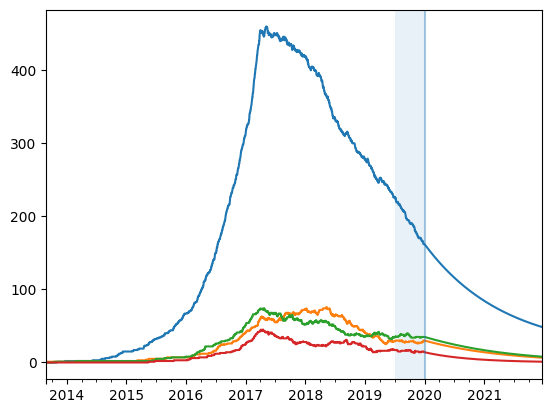

In [6]:
historic_pop = stats.stock.loc[:end_date]
combined_pop = pd.concat([historic_pop, predicted_pop], axis=0)

# Remove this to see individual sequences
combined_pop = combined_pop.groupby(level=1, axis=1).sum()

combined_pop.plot(legend=False)
pp.axvline(end_date, alpha=0.4)
pp.axvspan(start_date, end_date, alpha=0.1)
pp.show()

In [7]:
predictor = ModelPredictor.from_model(stats, start_date, end_date)
predicted_pop = predictor.predict(720 // 90, step_days=90, progress=True)  # Predict 720 days forward
predicted_pop.groupby(level=1, axis=1).sum()

2021-12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 36.58it/s]


placement_type,Fostering,Other,Residential,Supported
2020-03-31,134.804383,24.405190,28.706359,9.526660
2020-06-29,112.682215,19.831407,23.438256,6.482660
2020-09-27,94.677133,16.098295,19.085833,4.411293
2020-12-26,80.014309,13.055727,15.517554,3.001777
2021-03-26,68.065855,10.579193,12.605549,2.042637
2021-06-24,58.322831,8.565765,10.235582,1.389964
2021-09-22,50.372591,6.930595,8.309821,0.945837
2021-12-21,43.880461,5.603913,6.746397,0.643619


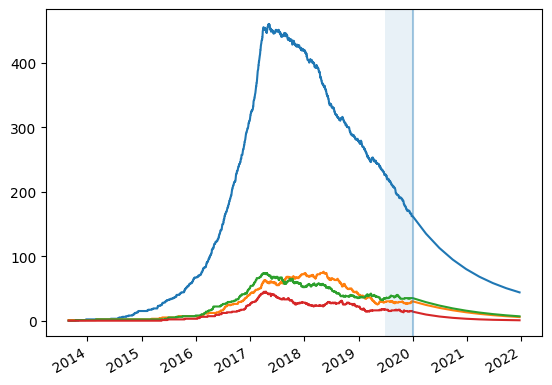

In [8]:
historic_pop = stats.stock.loc[:end_date]
combined_pop = pd.concat([historic_pop, predicted_pop], axis=0)

# Remove this to see individual sequences
combined_pop = combined_pop.groupby(level=1, axis=1).sum()

combined_pop.plot(legend=False)
pp.axvline(end_date, alpha=0.4)
pp.axvspan(start_date, end_date, alpha=0.1)
pp.show()